In [1]:
import nest_asyncio # para correr Stan en un Jupyter Notebook
nest_asyncio.apply()

In [17]:
import stan 
import pymc as pm
import arviz as az
import seaborn as sns
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt 
from IPython.display import display, Markdown 
import numpy as np

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

sampler_kwargs = {'chains': 4, 'cores': 4, 'return_inferencedata': True}

In [4]:
# Datos-COVID19/output/producto49/Positividad_Diaria_Media_T.csv
# positivity is casos pcr/pcr
meandpos = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto49/Positividad_Diaria_Media_T.csv')
meandpos['Fecha'] = pd.to_datetime(meandpos['Fecha'], format = '%Y-%m-%d')
meandpos = meandpos[meandpos['Fecha']>'2022-01']
meandpos['pcr'] = meandpos['pcr'].astype(int)
meandpos['casos pcr'] = meandpos['casos pcr'].astype(int)
meandpos['casos ag'] = meandpos['casos ag'].astype(int)

### Gráfico de positividad

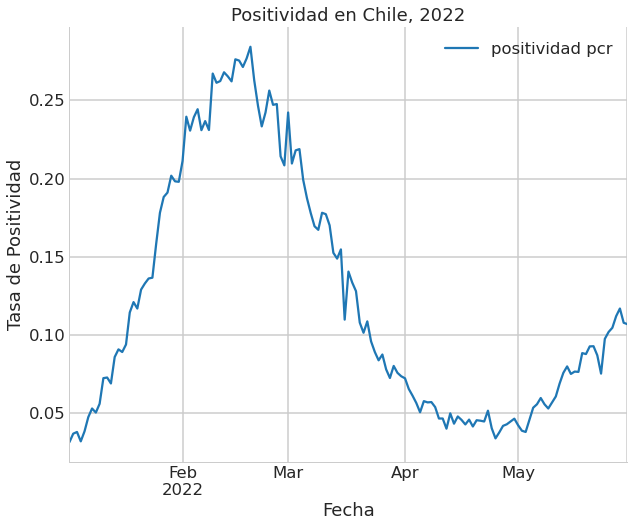

In [5]:
df = meandpos[['Fecha','positividad pcr']]
df.set_index('Fecha', inplace= True)
fig, ax = plt.subplots(figsize = (10,8))
df.plot(ax=ax)
ax.set(ylabel= 'Tasa de Positividad', title = 'Positividad en Chile, 2022')
sns.despine()

### Casos PCR

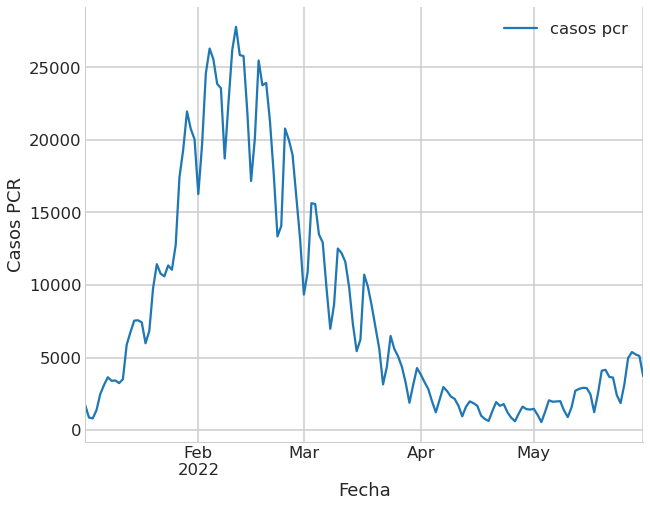

In [6]:
df = meandpos[['Fecha','casos pcr']]
df.set_index('Fecha', inplace= True)
fig, ax = plt.subplots(figsize = (10,8))
df.plot(ax=ax)
ax.set(ylabel= 'Casos PCR')
sns.despine()

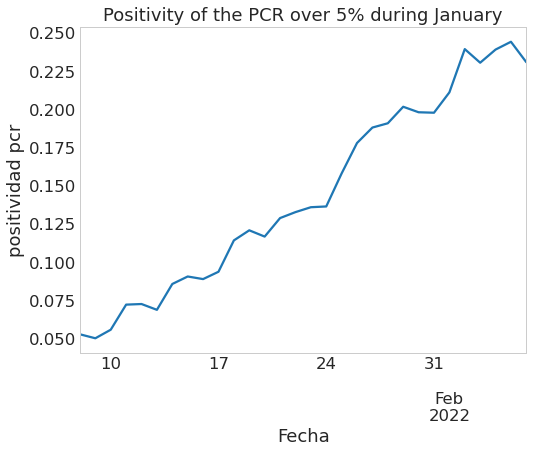

In [8]:
covid_over_5 = meandpos[meandpos['positividad pcr']>=0.05]
ax = covid_over_5.iloc[:30].plot('Fecha', 'positividad pcr', legend=False, figsize=(8,6))
ax.set_ylabel('positividad pcr')
ax.set_title('Positivity of the PCR over 5% during January')
ax.grid()

In [67]:
j = (covid_over_5.iloc[:30]['Fecha'] - covid_over_5['Fecha'].iat[0]).dt.days.values
confirmed = covid_over_5.iloc[:30]['positividad pcr'].values
type(j)

numpy.ndarray

In [36]:
confirmed = list(confirmed)

In [25]:
covid_over_5.iloc[:30]['Fecha']

654   2022-01-08
655   2022-01-09
656   2022-01-10
657   2022-01-11
658   2022-01-12
659   2022-01-13
660   2022-01-14
661   2022-01-15
662   2022-01-16
663   2022-01-17
664   2022-01-18
665   2022-01-19
666   2022-01-20
667   2022-01-21
668   2022-01-22
669   2022-01-23
670   2022-01-24
671   2022-01-25
672   2022-01-26
673   2022-01-27
674   2022-01-28
675   2022-01-29
676   2022-01-30
677   2022-01-31
678   2022-02-01
679   2022-02-02
680   2022-02-03
681   2022-02-04
682   2022-02-05
683   2022-02-06
Name: Fecha, dtype: datetime64[ns]

## 2. Build the model

In [43]:
stan_model = '''
data {
 int<lower = 1 > N;
 vector<lower = 0>[N] j;
 vector<lower = 0>[N] f;
}
parameters {
 real A;
 real b;
 real<lower = 0> error;
}
model {
  //priors
  A ~ normal(0, 100);
  b ~ normal(0.3, 0.3);
  error ~ normal(0, 100);
  
  f ~ normal(A * pow(1+b,j) , error);
}'''

In [44]:
data_dict = {
    'N' : len(j),
    'j' : j,
    'f' : confirmed 
}

## 3. Run prior predictive check

In [45]:
prior_stan = '''
generated quantities {
  real f_sim[N];
  real A;
  real b;
  real<lower = 0> error;
  A = normal_rng(0, 100);
  b = normal_rng(0.3, 0.3);
  error = fabs(normal_rng(0, 100));  
  for (i in 1:N){
    f_sim[i] = normal_rng(A * pow(1+b,j[i]), error);
  }
}
'''

In [46]:
prior_stan_code = stan_model + prior_stan
print(prior_stan_code)


data {
 int<lower = 1 > N;
 vector<lower = 0>[N] j;
 vector<lower = 0>[N] f;
}
parameters {
 real A;
 real b;
 real<lower = 0> error;
}
model {
  //priors
  A ~ normal(0, 100);
  b ~ normal(0.3, 0.3);
  error ~ normal(0, 100);
  
  f ~ normal(A * pow(1+b,j) , error);
}
generated quantities {
  real f_sim[N];
  real A;
  real b;
  real<lower = 0> error;
  A = normal_rng(0, 100);
  b = normal_rng(0.3, 0.3);
  error = fabs(normal_rng(0, 100));  
  for (i in 1:N){
    f_sim[i] = normal_rng(A * pow(1+b,j[i]), error);
  }
}



## 4. Fit the model

In [47]:
prior_stan_code = stan_model + prior_stan
prior_sm = stan.build(stan_model)
prior_fit = prior_sm.sampling(data=meandpos, iter=1000, chains=4, warmup=500, thin=1, seed=101)

Building...

cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
In file included from /home/brunopicasso/miniconda3/envs/stan/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:7,
                 from /home/brunopicasso/.cache/httpstan/4.7.2/models/eorub5o7/model_eorub5o7.cpp:2:
/home/brunopicasso/miniconda3/envs/stan/lib/python3.8/site-packages/httpstan/include/stan/io/dump.hpp: In member function ‘virtual std::vector<std::complex<double> > stan::io::dump::vals_c(const string&) const’:
/home/brunopicasso/miniconda3/envs/stan/lib/python3.8/site-packages/httpstan/include/stan/io/dump.hpp:694:52: warning: comparison of integer expressions of different signedness: ‘int’ and ‘std::vector<double, std::allocator<double> >::size_type’ {aka ‘long unsigned int’} [-Wsign-compare]
  694 |       for (comp_iter = 0, real_iter = 0; real_iter < val_r->second.first.size();
      |                                          ~~~~~~~~~~^~~~~~~~~~~~~~~~


Building: 27.6s, done.Messages from stanc:
Warning in '/tmp/httpstan_whvsarwh/model_eorub5o7.stan', line 16, column 20: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_whvsarwh/model_eorub5o7.stan', line 14, column 16: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).


RuntimeError: Error calling get_param_names: `Exception: variable does not exist; processing stage=data initialization; variable name=N; base type=int (in '/tmp/httpstan_exkehyvb/model_eorub5o7.stan', line 3, column 1 to column 19)`

### Thomas Wiecki's way


In [68]:
t = j
positivity = confirmed

with pm.Model() as model_expl:
    #Intercept
    a = pm.Normal('a', mu = 0, sigma = 100)
    
    #Slope
    b = pm.Normal('b', mu = 0.25, sigma = 0.1)

    #Exponential Regression
    growth = a*(1 + b) ** t

    #Error Term
    eps = pm.HalfNormal('eps', 100)

    #Likelihood
    pm.Normal('obs',
            mu = growth,
            sigma = eps,
            observed=confirmed)



In [70]:
with model_expl:
    prior_pred = pm.sample_prior_predictive()

[(0.0, 0.25),
 (0.0, 30.0),
 Text(0.5, 1.0, 'Prior predictive'),
 Text(0.5, 0, 'Dias de Enero'),
 Text(0, 0.5, 'Positivity')]

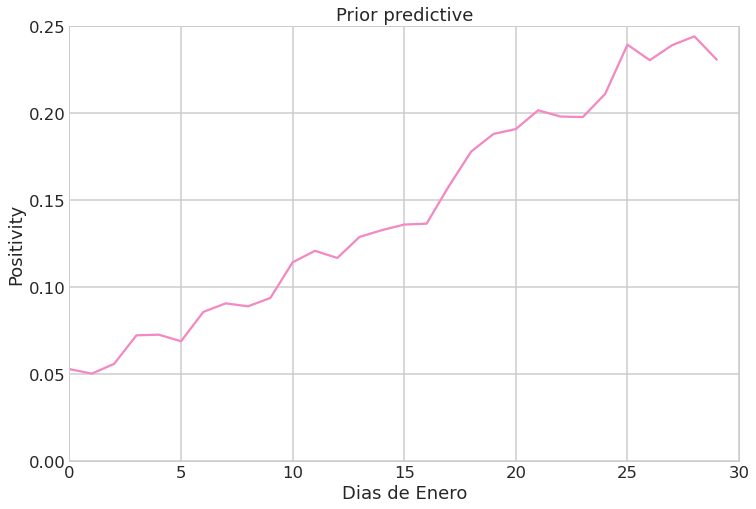

In [81]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(prior_pred['observed_data']['obs'].T, color = '#F388C2', alpha = 1)
ax.set(ylim = (0,.25), xlim = (0,30), title = 'Prior predictive', xlabel = "Dias de Enero", ylabel = 'Positivity')


In [83]:
with model_expl:
    trace = pm.sample(tune = 0, draws = 500,
                      return_inferencedata= True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/brunopicasso/miniconda3/envs/stan/lib/python3.8/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, eps]


Sampling 4 chains for 0 tune and 500 draw iterations (0 + 2_000 draws total) took 1 seconds.
There were 309 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 7.813e-11, but should be close to 0.8. Try to increase the number of tuning steps.
There were 440 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.02158, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is lar

/home/brunopicasso/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/brunopicasso/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/brunopicasso/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/brunopicasso/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single valu

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

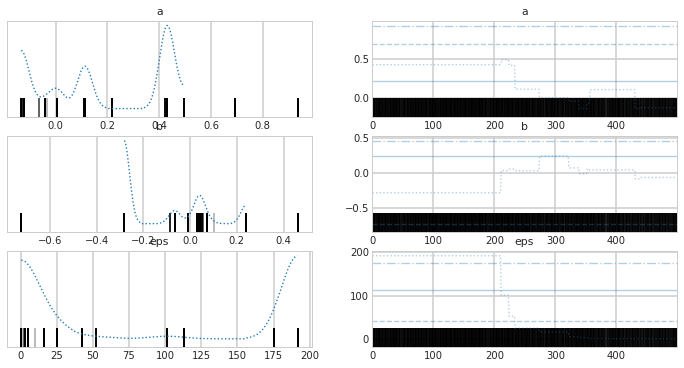

In [84]:
az.plot_trace(trace)

In [72]:
prior_pred

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [75]:
prior_pred['observed_data']['obs'].T

<xarray.DataArray 'obs' (obs_dim_0: 30)>
array([0.053 , 0.0504, 0.056 , 0.0724, 0.0728, 0.069 , 0.0859, 0.0908,
       0.0891, 0.0939, 0.1144, 0.121 , 0.1169, 0.129 , 0.1329, 0.1361,
       0.1366, 0.1582, 0.1781, 0.1882, 0.191 , 0.2018, 0.1982, 0.1979,
       0.2112, 0.2395, 0.2306, 0.2392, 0.2443, 0.2309])
Coordinates:
  * obs_dim_0  (obs_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29